# 1.神经网络拟合函数

本次作业的第一节，我们的目标是利用torch.nn这一模块实现通过神经网络拟合函数的任务，利用4次多项式函数来拟合余弦函数（定义域：$[-\pi,\pi]$）。
请作图展示拟合后的效果。
同学们可以参考课件的代码完成。

In [1]:
import torch
from torch import nn,optim,flatten
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import math
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict
torch.manual_seed(1) #设置随机种子以保证实验的可重复性
class Polynomial4(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))
        self.e = torch.nn.Parameter(torch.randn(()))
        
    def forward(self, x ):
        return self.a + self.b * x + self.c * x ** 2 + self.d * x **3 + self.e * x ** 4
    
    def __str__(self):
        return f"y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3 + {self.e.item()} x^4"

In [2]:
# 请仿照课上的PPT完成训练过程，下面的代码只是作为参考，可以随意修改
n = 4000
x = torch.linspace(-math.pi,math.pi,steps = n)
y = torch.cos(x)
model = Polynomial4()
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-7)

In [3]:
num_iter = 30000
for t in range(num_iter):
    #forward pass: compute predicted y by passing x to the model
    y_pred = model(x)

    #compute and print loss
    loss = criterion(y_pred,y)
    if t % ((num_iter/10)-1) == 0:
        print(f"iter: {t}, loss:{loss.item()/n}")
        
    #Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

iter: 0, loss:243.731515625
iter: 2999, loss:0.02461756134033203
iter: 5998, loss:0.00822498893737793
iter: 8997, loss:0.0029852633476257326
iter: 11996, loss:0.00123381507396698
iter: 14995, loss:0.0006417225003242492
iter: 17994, loss:0.00044098424911499025
iter: 20993, loss:0.0003728880286216736
iter: 23992, loss:0.0003497786521911621
iter: 26991, loss:0.00034193778038024903
iter: 29990, loss:0.00033927106857299807


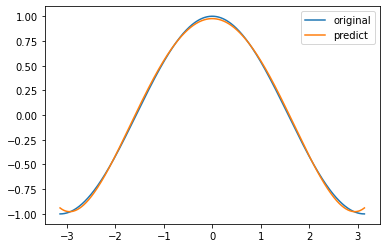

In [4]:
# 请利用matplotlib完成作图，画出余弦函数以及拟合的多项式函数在定义域内的图像
plt.plot(x,y,label='original')
plt.plot(x,y_pred.detach().numpy(),label='predict')
plt.legend()
plt.show()

# 2.卷积神经网络
本节我们将完成关于卷积神经网络的练习。练习分为两部分，首先是简单地手写卷积来完成边缘提取任务，该部分属于传统的图像识别范畴。然后，我们将实现一个卷积神经网络来完成对FashionMINST数据集进行分类的工作。


## 2.1 卷积边缘提取
边缘的特点是像素值在这里会发生跃迁，因此可以通过计算梯度的方式来判定边缘的位置。我们可以利用卷积和特定的算子来计算相邻像素的变化，常用的算子包括Sobel算子、Prewitt算子、Laplacian算子等，同学们也可以自行设计算子来对下面的图片进行边缘检测。
请使用填充保证输入、输出的图像尺寸相等

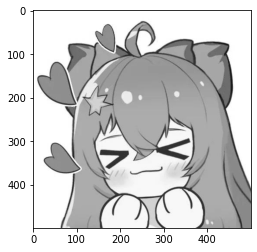

In [5]:
import cv2
diana = cv2.imread('./diana.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(diana,cmap ='gray')
plt.show()

首先我们设计卷积核，注意这里只进行卷积操作，因此不需要保存梯度，然后利用该卷积核进行卷积即可。

关于pytorch的权重初始化，可以参考[这里](https://blog.csdn.net/shanglianlm/article/details/85165523)，不过本次任务实际上我们只需要对weight赋值即可。请注意对nn.Module的weight赋值时需要将tensor转化为nn.Parameter类，否则会报错。同时我们需要对图像的shape进行略微的修改以适应Conv2d的要求

另外卷积后的结果可能会超出灰度图的范围，为了更好的显示效果可能需要后续处理。

In [6]:
class kernel(nn.Module):
    def __init__(self):
        super(kernel,self).__init__()
        self.conv = [[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]
        self.conv = torch.FloatTensor(self.conv).unsqueeze(0).unsqueeze(0)
        self.conv.weight = nn.Parameter(data=self.conv, requires_grad=False)
        
    def forward(self,x):
        return nn.functional.conv2d(x, self.conv.weight, padding=2)

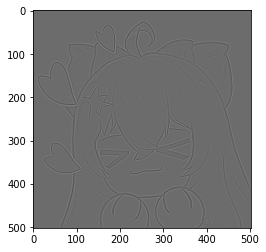

In [7]:
def convolution(image , kernel):
    image = torch.Tensor(image)
    image = torch.FloatTensor(image).unsqueeze(0).unsqueeze(0)
    return torch.squeeze(kernel.forward(image))

conv_kernel = kernel()
res = convolution(diana,conv_kernel)
plt.imshow(res,'gray')

## 2.2 基于卷积神经网络的图像分类
本节我们将在FashionMINST数据集上完成简单的图像分类任务，对于网络的设计和最终的分类成绩本次作业没有确切的要求，不过如果稍微调一下参的话取得80%+的正确率应该不算难。

In [8]:
#数据下载，这里可以直接下现成的Dataset，如果同学们想更进一步学习的话应该了解torch.utils.data.Dataset类的写法
training_data = datasets.FashionMNIST(
    root="./", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(
    root="./", train=False, download=True, transform=ToTensor())

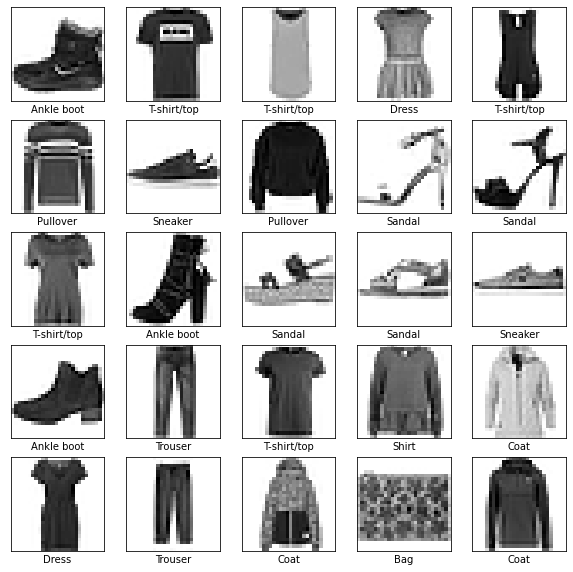

In [9]:
# 进行简单的可视化
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_data[i][0].squeeze(0), cmap=plt.cm.binary)
    plt.xlabel(labels[training_data[i][1]])
plt.show()

In [10]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):       
        '''
        input - 1x28x28
        C1 - 6@24x24 (5x5 kernel)
        tanh
        S2 - 6@12x12 (2x2 kernel, stride 2) Subsampling
        C3 - 16@8x8 (5x5 kernel, complicated shit)
        tanh
        S4 - 16@4x4 (2x2 kernel, stride 2) Subsampling
        C5 - 120@1x1 (4x4 kernel)
        F6 - 84
        F7 - 10 (output)
        '''
        
        super(NeuralNetwork, self).__init__()
        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6 , kernel_size = (5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size = (2,2), stride = 2)),
            
            ('c3', nn.Conv2d(6, 16 , kernel_size = (5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size = (2,2), stride = 2)),
            
            ('c5', nn.Conv2d(16, 120 , kernel_size = (4, 4))),
            ('relu5', nn.ReLU()),
        ]))
        
        #Full connect
        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim = 1))
        ]))
        
    def forward(self, x) :
        output = self.convnet(x)
        output = output.view(x.size(0), -1)
        output = self.fc(output)
        return output
    
net = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 2e-3)

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = 60000
    for batch, (image, label) in enumerate(dataloader):
        # TODO，训练函数
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, label)
        if batch % 100 == 0:
            print(f"{batch*len(label)} / {size} , loss: {loss.item():.6f}")
        
        loss.backward() #反向传播计算梯度
        optimizer.step() #更新模型

epochs = 100
net.train()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    #TODO
    train_loop(train_dataloader, net, criterion, optimizer)
print("训练完成!")

Epoch 1
-------------------------------
0 / 60000 , loss: 2.309402
6400 / 60000 , loss: 0.898844
12800 / 60000 , loss: 0.487656
19200 / 60000 , loss: 0.705085
25600 / 60000 , loss: 0.678757
32000 / 60000 , loss: 0.593341
38400 / 60000 , loss: 0.549684
44800 / 60000 , loss: 0.620114
51200 / 60000 , loss: 0.521312
57600 / 60000 , loss: 0.522979
Epoch 2
-------------------------------
0 / 60000 , loss: 0.427369
6400 / 60000 , loss: 0.450891
12800 / 60000 , loss: 0.318998
19200 / 60000 , loss: 0.530495
25600 / 60000 , loss: 0.502714
32000 / 60000 , loss: 0.494746
38400 / 60000 , loss: 0.462160
44800 / 60000 , loss: 0.524092
51200 / 60000 , loss: 0.434276
57600 / 60000 , loss: 0.377115
Epoch 3
-------------------------------
0 / 60000 , loss: 0.301803
6400 / 60000 , loss: 0.314292
12800 / 60000 , loss: 0.249988
19200 / 60000 , loss: 0.504468
25600 / 60000 , loss: 0.430665
32000 / 60000 , loss: 0.431255
38400 / 60000 , loss: 0.415296
44800 / 60000 , loss: 0.494612
51200 / 60000 , loss: 0.415

44800 / 60000 , loss: 0.272255
51200 / 60000 , loss: 0.190926
57600 / 60000 , loss: 0.189813
Epoch 25
-------------------------------
0 / 60000 , loss: 0.133947
6400 / 60000 , loss: 0.102810
12800 / 60000 , loss: 0.131245
19200 / 60000 , loss: 0.163205
25600 / 60000 , loss: 0.175483
32000 / 60000 , loss: 0.280639
38400 / 60000 , loss: 0.158522
44800 / 60000 , loss: 0.248058
51200 / 60000 , loss: 0.206224
57600 / 60000 , loss: 0.222143
Epoch 26
-------------------------------
0 / 60000 , loss: 0.122493
6400 / 60000 , loss: 0.146405
12800 / 60000 , loss: 0.137915
19200 / 60000 , loss: 0.218934
25600 / 60000 , loss: 0.177181
32000 / 60000 , loss: 0.384321
38400 / 60000 , loss: 0.259092
44800 / 60000 , loss: 0.203020
51200 / 60000 , loss: 0.196196
57600 / 60000 , loss: 0.212964
Epoch 27
-------------------------------
0 / 60000 , loss: 0.146150
6400 / 60000 , loss: 0.123838
12800 / 60000 , loss: 0.116796
19200 / 60000 , loss: 0.207250
25600 / 60000 , loss: 0.138670
32000 / 60000 , loss: 0.

25600 / 60000 , loss: 0.120718
32000 / 60000 , loss: 0.248800
38400 / 60000 , loss: 0.219575
44800 / 60000 , loss: 0.104743
51200 / 60000 , loss: 0.130213
57600 / 60000 , loss: 0.205746
Epoch 49
-------------------------------
0 / 60000 , loss: 0.159999
6400 / 60000 , loss: 0.170406
12800 / 60000 , loss: 0.036598
19200 / 60000 , loss: 0.158835
25600 / 60000 , loss: 0.127421
32000 / 60000 , loss: 0.229674
38400 / 60000 , loss: 0.090079
44800 / 60000 , loss: 0.114005
51200 / 60000 , loss: 0.118020
57600 / 60000 , loss: 0.217447
Epoch 50
-------------------------------
0 / 60000 , loss: 0.054653
6400 / 60000 , loss: 0.096731
12800 / 60000 , loss: 0.117367
19200 / 60000 , loss: 0.150664
25600 / 60000 , loss: 0.129475
32000 / 60000 , loss: 0.241284
38400 / 60000 , loss: 0.199197
44800 / 60000 , loss: 0.090066
51200 / 60000 , loss: 0.201669
57600 / 60000 , loss: 0.179489
Epoch 51
-------------------------------
0 / 60000 , loss: 0.097317
6400 / 60000 , loss: 0.144631
12800 / 60000 , loss: 0.

6400 / 60000 , loss: 0.169777
12800 / 60000 , loss: 0.057543
19200 / 60000 , loss: 0.108766
25600 / 60000 , loss: 0.223102
32000 / 60000 , loss: 0.222774
38400 / 60000 , loss: 0.077146
44800 / 60000 , loss: 0.055526
51200 / 60000 , loss: 0.126611
57600 / 60000 , loss: 0.303779
Epoch 73
-------------------------------
0 / 60000 , loss: 0.065941
6400 / 60000 , loss: 0.096458
12800 / 60000 , loss: 0.075537
19200 / 60000 , loss: 0.208651
25600 / 60000 , loss: 0.135806
32000 / 60000 , loss: 0.113629
38400 / 60000 , loss: 0.134687
44800 / 60000 , loss: 0.105762
51200 / 60000 , loss: 0.169036
57600 / 60000 , loss: 0.113482
Epoch 74
-------------------------------
0 / 60000 , loss: 0.037135
6400 / 60000 , loss: 0.128722
12800 / 60000 , loss: 0.050786
19200 / 60000 , loss: 0.076465
25600 / 60000 , loss: 0.246227
32000 / 60000 , loss: 0.128240
38400 / 60000 , loss: 0.049278
44800 / 60000 , loss: 0.147464
51200 / 60000 , loss: 0.243197
57600 / 60000 , loss: 0.085464
Epoch 75
---------------------

57600 / 60000 , loss: 0.188132
Epoch 96
-------------------------------
0 / 60000 , loss: 0.051297
6400 / 60000 , loss: 0.127465
12800 / 60000 , loss: 0.039550
19200 / 60000 , loss: 0.142445
25600 / 60000 , loss: 0.096707
32000 / 60000 , loss: 0.094455
38400 / 60000 , loss: 0.073406
44800 / 60000 , loss: 0.061996
51200 / 60000 , loss: 0.082618
57600 / 60000 , loss: 0.042170
Epoch 97
-------------------------------
0 / 60000 , loss: 0.110510
6400 / 60000 , loss: 0.148636
12800 / 60000 , loss: 0.036745
19200 / 60000 , loss: 0.089646
25600 / 60000 , loss: 0.059380
32000 / 60000 , loss: 0.064108
38400 / 60000 , loss: 0.139026
44800 / 60000 , loss: 0.049703
51200 / 60000 , loss: 0.062180
57600 / 60000 , loss: 0.205808
Epoch 98
-------------------------------
0 / 60000 , loss: 0.062376
6400 / 60000 , loss: 0.085779
12800 / 60000 , loss: 0.013311
19200 / 60000 , loss: 0.106494
25600 / 60000 , loss: 0.084592
32000 / 60000 , loss: 0.091008
38400 / 60000 , loss: 0.141042
44800 / 60000 , loss: 0.

In [15]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    total_correct = 0
    avg_loss = 0.0
    with torch.no_grad():
        for image, label in dataloader:
            output = model(image)
            avg_loss += loss_fn(output, label)
            pred = output.detach().max(1)[1]
            total_correct += pred.eq(label.view_as(pred)).sum()
        avg_loss /= len(test_data)
        print(f"Average loss: {avg_loss:.5f}")
        print(f"Accuracy: {total_correct/len(test_data)*100:.2f}%")

In [16]:
test_loop(test_dataloader,net,criterion)

Average loss: 0.01555
Accuracy: 88.02%
